In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
from skimage import io
from torch.utils.data import (Dataset,DataLoader) 

In [2]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_directory = '/content/drive/MyDrive/SoftComputing Assignment/training-c.csv'
df = pd.read_csv(main_directory, sep=",")
print(df)

         filename           original filename  ...  contributing team  database name
0      c00000.png  Scan_280_digit_6_num_7.png  ...   Buet_Backpropers     training-c
1      c00001.png   Scan_29_digit_1_num_1.png  ...   Buet_Backpropers     training-c
2      c00002.png  Scan_131_digit_3_num_1.png  ...   Buet_Backpropers     training-c
3      c00003.png  Scan_160_digit_2_num_2.png  ...   Buet_Backpropers     training-c
4      c00004.png  Scan_202_digit_7_num_0.png  ...   Buet_Backpropers     training-c
...           ...                         ...  ...                ...            ...
24293  c24293.png  Scan_167_digit_3_num_4.png  ...   Buet_Backpropers     training-c
24294  c24294.png  Scan_174_digit_2_num_8.png  ...   Buet_Backpropers     training-c
24295  c24295.png  Scan_152_digit_7_num_4.png  ...   Buet_Backpropers     training-c
24296  c24296.png  Scan_123_digit_2_num_2.png  ...   Buet_Backpropers     training-c
24297  c24297.png    Scan_2_digit_7_num_6.png  ...   Buet_Backpro

In [5]:
df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [6]:
df = df.drop(['original filename','scanid','database name original', 'contributing team','database name'], axis = 1)

In [7]:
df.to_csv('/content/drive/MyDrive/SoftComputing Assignment/modified.csv',index = False)

In [8]:
batch_size = 20
input_dim = 80*80 
output_dim = 10
learning_rate = 0.001 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class HandWrittenNumberRecognition(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [10]:
transform_Img = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(80),
                                    transforms.ToTensor()])

In [11]:
dataset = HandWrittenNumberRecognition(
    csv_file="/content/drive/MyDrive/SoftComputing Assignment/modified.csv",
    root_dir="/content/drive/MyDrive/root/training-c",
    transform=transform_Img
)

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19438,4860])
print(len(train_dataset))
print(len(test_dataset))

19438
4860


In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [14]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
      
        self.linear_1 = nn.Linear(input_size,300)
        self.sigm_1 = nn.Sigmoid()

        self.linear_2 = nn.Linear(300, 280)
        self.sigm_2   = nn.Sigmoid()

        self.linear_3 = nn.Linear(280, 260)
        self.sigm_3 =  nn.Sigmoid()

        self.linear_4 = nn.Linear(260, 240)
        self.sigm_4   =  nn.Sigmoid()

        self.linear_5 = nn.Linear(240, 220)
        self.sigm_5 =  nn.Sigmoid()

        self.linear_6 = nn.Linear(220, 200)
        self.sigm_6 =  nn.Sigmoid()

        self.linear_out = nn.Linear(200,num_classes)

    def forward(self, x):
       
        out  = self.linear_1(x)
        out =  self.sigm_1(out)
        
        out  = self.linear_2(out)
        out =  self.sigm_2(out)

        out  = self.linear_3(out)
        out =  self.sigm_3(out)

        out  = self.linear_4(out)
        out =  self.sigm_4(out)

        out  = self.linear_5(out)
        out =  self.sigm_5(out)

        out  = self.linear_6(out)
        out =  self.sigm_6(out)
        
        probas  = self.linear_out(out)
        return probas



model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.7)

In [15]:
iter = 0
total_loss = []
iteration = []
correctly_classified_PerEpoch = []
accuracy_perEpoch = []
num_of_epoch = []
for epoch in range(25):
    print('Epoch: ',epoch+1)
    num_of_epoch.append(epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 80*80).to(device)

        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        print('Iteration no: ',iter)
        if iter % 1200 == 0:
            print('loss in iteration ',iter,'= ',loss.item())
            total_loss.append(loss.item())
            iteration.append(iter)

    correct = 0
    total = 0
    for images, labels in test_loader:
          
          images = images.view(-1,80*80).to(device)
          outputs = model(images)
 
          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)
 
          if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
                correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    accuracy_perEpoch.append(accuracy)
    correctly_classified_PerEpoch.append(correct.item())
    print('Total Data: {}.  CorrectlyPredicted: {}.'.format(total,correct))
    print('Accuracy in epoch ',epoch+1,'=',accuracy)

Streaming output truncated to the last 5000 lines.
Iteration no:  19322
Iteration no:  19323
Iteration no:  19324
Iteration no:  19325
Iteration no:  19326
Iteration no:  19327
Iteration no:  19328
Iteration no:  19329
Iteration no:  19330
Iteration no:  19331
Iteration no:  19332
Iteration no:  19333
Iteration no:  19334
Iteration no:  19335
Iteration no:  19336
Iteration no:  19337
Iteration no:  19338
Iteration no:  19339
Iteration no:  19340
Iteration no:  19341
Iteration no:  19342
Iteration no:  19343
Iteration no:  19344
Iteration no:  19345
Iteration no:  19346
Iteration no:  19347
Iteration no:  19348
Iteration no:  19349
Iteration no:  19350
Iteration no:  19351
Iteration no:  19352
Iteration no:  19353
Iteration no:  19354
Iteration no:  19355
Iteration no:  19356
Iteration no:  19357
Iteration no:  19358
Iteration no:  19359
Iteration no:  19360
Iteration no:  19361
Iteration no:  19362
Iteration no:  19363
Iteration no:  19364
Iteration no:  19365
Iteration no:  19366
Iter

In [16]:
root_path = '/content/drive/MyDrive/SoftComputing Assignment/Exp_02_07/ALLCOVERED'
save_model = True
 
if save_model is True:
    torch.save(model.state_dict(), root_path + '170104027_Exp2_7.pkl') 

In [17]:
print('loss count after every 750 iteration: ',total_loss)
print('iteration count: ',iteration)
print('Correctly classfied per epoch: ',correctly_classified_PerEpoch)
print('accuracy per epoch: ',accuracy_perEpoch)
print('Epoch list: ',num_of_epoch)

loss count after every 750 iteration:  [2.313185214996338, 2.313047170639038, 2.3057098388671875, 2.3270153999328613, 2.3023765087127686, 2.3031792640686035, 2.3140718936920166, 2.2962758541107178, 2.326653242111206, 2.307743549346924, 2.304417610168457, 2.3393378257751465, 2.3033628463745117, 2.305110454559326, 2.2985942363739014, 2.3063111305236816, 2.3129138946533203, 2.2868094444274902, 2.3044400215148926, 2.309215545654297]
iteration count:  [1200, 2400, 3600, 4800, 6000, 7200, 8400, 9600, 10800, 12000, 13200, 14400, 15600, 16800, 18000, 19200, 20400, 21600, 22800, 24000]
Correctly classfied per epoch:  [470, 476, 470, 470, 476, 518, 470, 460, 476, 470, 470, 476, 476, 470, 511, 491, 469, 476, 491, 469, 491, 491, 476, 470, 518]
accuracy per epoch:  [9.670781893004115, 9.794238683127572, 9.670781893004115, 9.670781893004115, 9.794238683127572, 10.65843621399177, 9.670781893004115, 9.465020576131687, 9.794238683127572, 9.670781893004115, 9.670781893004115, 9.794238683127572, 9.794238

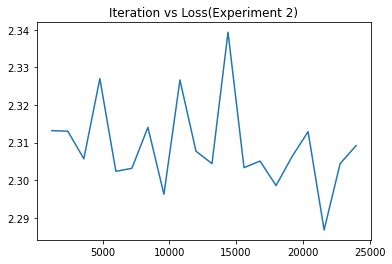

In [18]:
plt.plot(iteration,total_loss)
plt.title('Iteration vs Loss(Experiment 2)')
plt.show()

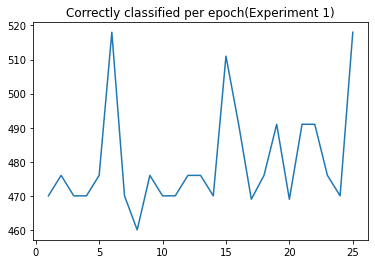

In [19]:
plt.plot(num_of_epoch,correctly_classified_PerEpoch)
plt.title('Correctly classified per epoch(Experiment 1)')
plt.show()

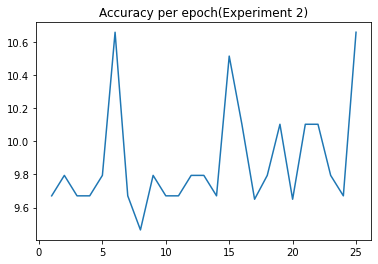

In [20]:
plt.plot(num_of_epoch,accuracy_perEpoch)
plt.title('Accuracy per epoch(Experiment 2)')
plt.show()